In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)
pd.set_option("display.max_colwidth", -1)

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### 1. DATA PREPROCESSING

In [3]:
train=pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_test.csv",encoding='latin1')
df = test.append(train).reset_index(drop=True)

In [4]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1",Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and loved ones from #coronavirus. ?,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg staged event?\r\r\n\r\r\nhttps://t.co/IASiReGPC4\r\r\n\r\r\n#QAnon #QAnon2018 #QAnon2020 \r\r\n#Election2020 #CDC https://t.co/29isZOewxu,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News #Corvid19 #7NewsMelb #dunnypapergate #Costco One week everyone buying baby milk powder the next everyone buying up toilet paper. https://t.co/ScZryVvsIh,Neutral


In [5]:
df['Sentiment'].value_counts()

Positive              12369
Negative              10958
Neutral               8332 
Extremely Positive    7223 
Extremely Negative    6073 
Name: Sentiment, dtype: int64

In [6]:
df_ = df[["OriginalTweet", "Sentiment"]]
df_.head()

,OriginalTweet,Sentiment
0,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1",Extremely Negative
1,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive
2,Find out how you can protect yourself and loved ones from #coronavirus. ?,Extremely Positive
3,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg staged event?\r\r\n\r\r\nhttps://t.co/IASiReGPC4\r\r\n\r\r\n#QAnon #QAnon2018 #QAnon2020 \r\r\n#Election2020 #CDC https://t.co/29isZOewxu,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News #Corvid19 #7NewsMelb #dunnypapergate #Costco One week everyone buying baby milk powder the next everyone buying up toilet paper. https://t.co/ScZryVvsIh,Neutral


#### 1.1 Text Preprocesing

Lower - upper case

In [7]:
df_["OriginalTweet"]=df_["OriginalTweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
df_.head()

,OriginalTweet,Sentiment
0,"trending: new yorkers encounter empty supermarket shelves (pictured, wegmans in brooklyn), sold-out online grocers (foodkick, maxdelivery) as #coronavirus-fearing shoppers stock up https://t.co/gr76pcrlwh https://t.co/ivmkmsqdt1",Extremely Negative
1,"when i couldn't find hand sanitizer at fred meyer, i turned to #amazon. but $114.97 for a 2 pack of purell??!!check out how #coronavirus concerns are driving up prices. https://t.co/ygbipbflmy",Positive
2,find out how you can protect yourself and loved ones from #coronavirus. ?,Extremely Positive
3,#panic buying hits #newyork city as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #bigapple 1st confirmed #coronavirus patient or a #bloomberg staged event? https://t.co/iasiregpc4 #qanon #qanon2018 #qanon2020 #election2020 #cdc https://t.co/29iszoewxu,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #coronavirusupdate #covid_19 #9news #corvid19 #7newsmelb #dunnypapergate #costco one week everyone buying baby milk powder the next everyone buying up toilet paper. https://t.co/sczryvvsih,Neutral


Dropping punctuation marks

In [8]:
df_["OriginalTweet"]=df_["OriginalTweet"].str.replace('[^\w\s]', '')
df_.head()

,OriginalTweet,Sentiment
0,trending new yorkers encounter empty supermarket shelves pictured wegmans in brooklyn soldout online grocers foodkick maxdelivery as coronavirusfearing shoppers stock up httpstcogr76pcrlwh httpstcoivmkmsqdt1,Extremely Negative
1,when i couldnt find hand sanitizer at fred meyer i turned to amazon but 11497 for a 2 pack of purellcheck out how coronavirus concerns are driving up prices httpstcoygbipbflmy,Positive
2,find out how you can protect yourself and loved ones from coronavirus,Extremely Positive
3,panic buying hits newyork city as anxious shoppers stock up on foodampmedical supplies after healthcare worker in her 30s becomes bigapple 1st confirmed coronavirus patient or a bloomberg staged event httpstcoiasiregpc4 qanon qanon2018 qanon2020 election2020 cdc httpstco29iszoewxu,Negative
4,toiletpaper dunnypaper coronavirus coronavirusaustralia coronavirusupdate covid_19 9news corvid19 7newsmelb dunnypapergate costco one week everyone buying baby milk powder the next everyone buying up toilet paper httpstcosczryvvsih,Neutral


Dropping numbers

In [9]:
df_["OriginalTweet"]=df_["OriginalTweet"].str.replace('\d', '')
df_.head()

,OriginalTweet,Sentiment
0,trending new yorkers encounter empty supermarket shelves pictured wegmans in brooklyn soldout online grocers foodkick maxdelivery as coronavirusfearing shoppers stock up httpstcogrpcrlwh httpstcoivmkmsqdt,Extremely Negative
1,when i couldnt find hand sanitizer at fred meyer i turned to amazon but for a pack of purellcheck out how coronavirus concerns are driving up prices httpstcoygbipbflmy,Positive
2,find out how you can protect yourself and loved ones from coronavirus,Extremely Positive
3,panic buying hits newyork city as anxious shoppers stock up on foodampmedical supplies after healthcare worker in her s becomes bigapple st confirmed coronavirus patient or a bloomberg staged event httpstcoiasiregpc qanon qanon qanon election cdc httpstcoiszoewxu,Negative
4,toiletpaper dunnypaper coronavirus coronavirusaustralia coronavirusupdate covid_ news corvid newsmelb dunnypapergate costco one week everyone buying baby milk powder the next everyone buying up toilet paper httpstcosczryvvsih,Neutral


Stopwords

In [10]:
sw=stopwords.words('english')
df_["OriginalTweet"]=df_["OriginalTweet"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
df_.head()

,OriginalTweet,Sentiment
0,trending new yorkers encounter empty supermarket shelves pictured wegmans brooklyn soldout online grocers foodkick maxdelivery coronavirusfearing shoppers stock httpstcogrpcrlwh httpstcoivmkmsqdt,Extremely Negative
1,couldnt find hand sanitizer fred meyer turned amazon pack purellcheck coronavirus concerns driving prices httpstcoygbipbflmy,Positive
2,find protect loved ones coronavirus,Extremely Positive
3,panic buying hits newyork city anxious shoppers stock foodampmedical supplies healthcare worker becomes bigapple st confirmed coronavirus patient bloomberg staged event httpstcoiasiregpc qanon qanon qanon election cdc httpstcoiszoewxu,Negative
4,toiletpaper dunnypaper coronavirus coronavirusaustralia coronavirusupdate covid_ news corvid newsmelb dunnypapergate costco one week everyone buying baby milk powder next everyone buying toilet paper httpstcosczryvvsih,Neutral


Rare Words

In [11]:
dropping=pd.Series(' '.join(df_['OriginalTweet']).split()).value_counts()[-1000:]
df_["OriginalTweet"]=df_["OriginalTweet"].apply(lambda x: " ".join(x for x in x.split() if x not in dropping))

Lemmatization

In [12]:
df_["OriginalTweet"]=df_["OriginalTweet"].apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))
df_.head()

,OriginalTweet,Sentiment
0,trending new yorkers encounter empty supermarket shelf pictured wegmans brooklyn soldout online grocer foodkick maxdelivery coronavirusfearing shopper stock httpstcogrpcrlwh httpstcoivmkmsqdt,Extremely Negative
1,couldnt find hand sanitizer fred meyer turned amazon pack purellcheck coronavirus concern driving price httpstcoygbipbflmy,Positive
2,find protect loved one coronavirus,Extremely Positive
3,panic buying hit newyork city anxious shopper stock foodampmedical supply healthcare worker becomes bigapple st confirmed coronavirus patient bloomberg staged event httpstcoiasiregpc qanon qanon qanon election cdc httpstcoiszoewxu,Negative
4,toiletpaper dunnypaper coronavirus coronavirusaustralia coronavirusupdate covid_ news corvid newsmelb dunnypapergate costco one week everyone buying baby milk powder next everyone buying toilet paper httpstcosczryvvsih,Neutral


### 2. DATA VISUALIZATION

Word Cloud

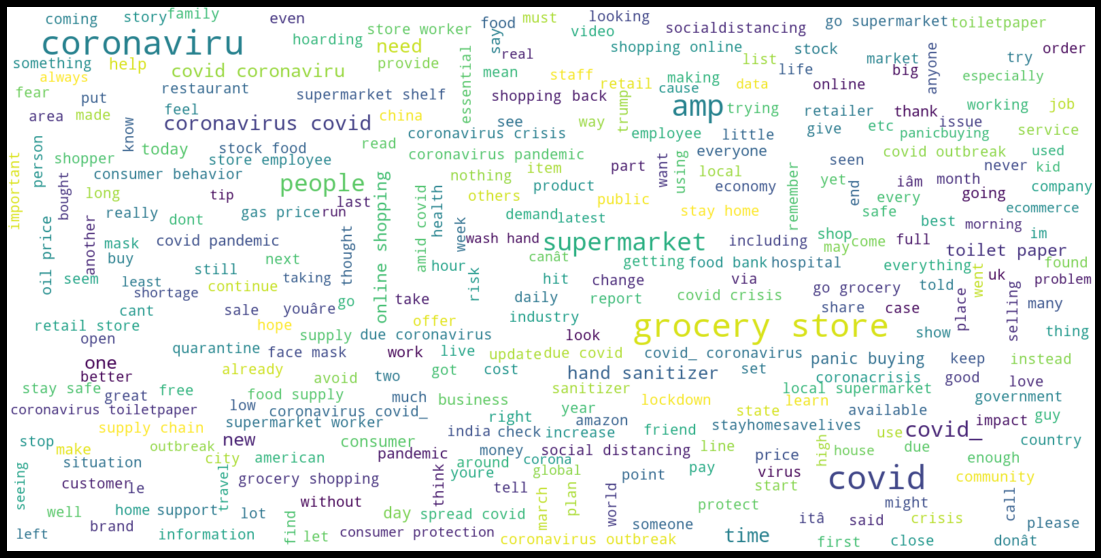

In [13]:
text = " ".join(i for i in df_.OriginalTweet)
wordcloud = WordCloud(max_font_size=50,
                      max_words=300,
                      background_color="white",
                     width=1600, height=800).generate(text)
plt.figure(figsize=(20,10),facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 3. SENTIMENT ANALYSIS

In [14]:
sia = SentimentIntensityAnalyzer()
df_["sentiment_label"] = df_["OriginalTweet"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df_.head(15)

,OriginalTweet,Sentiment,sentiment_label
0,trending new yorkers encounter empty supermarket shelf pictured wegmans brooklyn soldout online grocer foodkick maxdelivery coronavirusfearing shopper stock httpstcogrpcrlwh httpstcoivmkmsqdt,Extremely Negative,neg
1,couldnt find hand sanitizer fred meyer turned amazon pack purellcheck coronavirus concern driving price httpstcoygbipbflmy,Positive,neg
2,find protect loved one coronavirus,Extremely Positive,pos
3,panic buying hit newyork city anxious shopper stock foodampmedical supply healthcare worker becomes bigapple st confirmed coronavirus patient bloomberg staged event httpstcoiasiregpc qanon qanon qanon election cdc httpstcoiszoewxu,Negative,neg
4,toiletpaper dunnypaper coronavirus coronavirusaustralia coronavirusupdate covid_ news corvid newsmelb dunnypapergate costco one week everyone buying baby milk powder next everyone buying toilet paper httpstcosczryvvsih,Neutral,neg
5,remember last time paid gallon regular gas los angelesprices pump going look coronavirus impacting price pm abc httpstcopyzqymuv,Neutral,neg
6,voting age coronavirus hand sanitizer supertuesday httpstcozbelodk,Positive,pos
7,drtedros canât stop covid without protecting healthworkers price surgical mask increased sixfold n respirator trebled amp gown cost twice muchdrtedros coronavirus,Neutral,neg
8,hi twitter pharmacist sell hand sanitizer living exists like mask sold fuck everywhere worried use soap visit twenty pharmacy looking last bottle pharmacy full sick people,Extremely Negative,neg
9,anyone supermarket last day went normal shop last night amp sight greeted barmy btw whatâs special tinned tomato covid_ dublin httpstcorgsmxuxr,Extremely Positive,pos


### FEATURE ENGINEERING

* Count Vectors
* TF - IDF Vectors (words, characters, n-grams)
* Word Embeddings

In [15]:
train_x, test_x, train_y, test_y = train_test_split(df_["OriginalTweet"],
                                                    df_["sentiment_label"],
                                                    random_state=17)

In [16]:
train_x.shape

(33716,)

In [17]:
test_x.shape

(11239,)

In [18]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

### Count Vectors

In [19]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)
x_train_count = vectorizer.transform(train_x)
x_test_count = vectorizer.transform(test_x)

### TF-IDF Word Level

In [20]:
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

### TF-IDF N-Gram Level

In [21]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3)).fit(train_x)
x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(train_x)
x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(test_x)

### TF-IDF Characters Level

In [22]:
tf_idf_chars_vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2, 3)).fit(train_x)
x_train_tf_idf_chars = tf_idf_chars_vectorizer.transform(train_x)
x_test_tf_idf_chars = tf_idf_chars_vectorizer.transform(test_x)

# RandomForestClassifier

In [23]:
# TF-IDF Word-Level
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()

0.7876147635360393

In [24]:
# TF-IDF N-GRAM
rf_model = RandomForestClassifier().fit(x_train_tf_idf_ngram, train_y)
cross_val_score(rf_model, x_test_tf_idf_ngram, test_y, cv=5, n_jobs=-1).mean()

0.6313724348954002

In [25]:
# TF-IDF CHARLEVEL
rf_model = RandomForestClassifier().fit(x_train_tf_idf_chars, train_y)
cross_val_score(rf_model, x_test_tf_idf_chars, test_y, cv=5, n_jobs=-1).mean()

0.6871610150030013

In [26]:
# Count Vectors
rf_model = RandomForestClassifier().fit(x_train_count, train_y)
cross_val_score(rf_model, x_test_count, test_y, cv=5).mean()

0.8101261547623008

### Example

In [27]:
new_comment = pd.Series("I really need toilet paper")
new_comment = CountVectorizer().fit(train_x).transform(new_comment)

rf_model.predict(new_comment)

array([0])

In [28]:
new_comment = pd.Series("Good")
new_comment = CountVectorizer().fit(train_x).transform(new_comment)

rf_model.predict(new_comment)

array([1])